# Enhancing Strategies with Neural Networks

Credits: Alex Honchar

Source: https://github.com/Rachnog/Deep-Trading/blob/master/volatility/volatility.py


In [1]:
import numpy as np
import json
import glob

import pandas as pd
import matplotlib.pylab as plt

In [2]:
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute, Reshape, Lambda
from keras.layers import Merge, Input, concatenate
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Convolution1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses
from keras.layers.noise import *


from keras import backend as K
import seaborn as sns
sns.despine()

Using TensorFlow backend.


In [5]:
from pyti.williams_percent_r import williams_percent_r
from pyti.relative_strength_index import relative_strength_index

import nolds

In [6]:
def data2change(data):
    change = pd.DataFrame(data).pct_change()
    change = change.replace([np.inf, -np.inf], np.nan)
    change = change.fillna(0.).values.tolist()
    change = [c[0] for c in change]
    return change

In [7]:
def remap(x, in_min, in_max, out_min, out_max):
  return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

In [8]:
def moving_average_convergence(group, nslow=12, nfast=6):
    emaslow = pd.ewma(group, span=nslow, min_periods=1).values.tolist()
    emafast = pd.ewma(group, span=nfast, min_periods=1).values.tolist()
    return np.array(emafast) -np.array(emaslow)

In [9]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [10]:
def create_Xt_Yt(X, y, percentage=0.95):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

In [11]:
TEST_SET = 0.9
WINDOW = 30
STEP = 1
FORECAST = 14
ROLLING = 30

In [26]:
data_original = pd.read_csv('dataset/700_data_from_IB_1day.csv')[::-1]

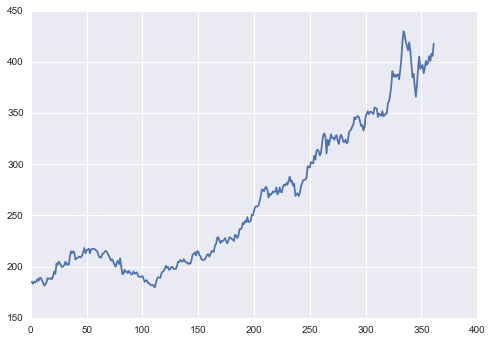

In [27]:
plt.plot(data_original['close'])
plt.show()

In [29]:
openp = data_original.loc[:, 'open'].tolist()
highp = data_original.loc[:, 'high'].tolist()
lowp = data_original.loc[:, 'low'].tolist()
closep = data_original.loc[:, 'close'].tolist()
volumep = data_original.loc[:, 'volume'].tolist()

In [30]:
ma30 = pd.DataFrame(closep).rolling(14).mean().values.tolist()
ma30 = [v[0] for v in ma30]
ma60 = pd.DataFrame(closep).rolling(30).mean().values.tolist()
ma60 = [v[0] for v in ma60]

In [39]:
#nine_period_high = pd.rolling_max(pd.DataFrame(highp), window= int(ROLLING / 2))
nine_period_high = pd.DataFrame(highp).rolling(window = int(ROLLING / 2)).max()
#nine_period_low = pd.rolling_min(pd.DataFrame(lowp), window=  int(ROLLING / 2))
nine_period_low = pd.DataFrame(lowp).rolling(window = int(ROLLING /2)).min()
ichimoku = (nine_period_high + nine_period_low) /2
ichimoku = ichimoku.replace([np.inf, -np.inf], np.nan)
ichimoku = ichimoku.fillna(0.).values.tolist()


In [40]:
macd_indie = moving_average_convergence(pd.DataFrame(closep))

/Users/hussainmohammadyousuf/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(span=12,min_periods=1,adjust=True,ignore_na=False).mean()
  
/Users/hussainmohammadyousuf/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(span=6,min_periods=1,adjust=True,ignore_na=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
wpr = williams_percent_r(closep)
rsi = relative_strength_index(closep,  ROLLING / 2)

In [42]:
volatility1 = pd.DataFrame(closep).rolling(ROLLING).std().values#.tolist()
volatility2 = pd.DataFrame(closep).rolling(ROLLING).var().values#.tolist()

In [43]:
volatility = volatility1 / volatility2
volatility = [v[0] for v in volatility]

In [44]:
rolling_skewness = pd.DataFrame(closep).rolling(ROLLING).skew().values 
rolling_kurtosis = pd.DataFrame(closep).rolling(ROLLING).kurt().values 

In [60]:
X, Y = [], []
for i in range(WINDOW, len(data_original)-1, STEP): 
    try:
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]
        volat = volatility[i:i+WINDOW]
        rsk = rolling_skewness[i:i+WINDOW]
        rku = rolling_kurtosis[i:i+WINDOW]
        macd = macd_indie[i:i+WINDOW]
        williams = wpr[i:i+WINDOW]
        relative = rsi[i:i+WINDOW]
        ichi = ichimoku[i:i+WINDOW]

        #if closep[i+WINDOW+FORECAST] < 0.0001 or closep[i+WINDOW+FORECAST] > 10000:
        #  continue


        macd = remap(np.array(macd), np.array(macd).min(), np.array(macd).max(), -1, 1)
        williams = remap(np.array(williams), np.array(williams).min(), np.array(williams).max(), -1, 1)
        relative = remap(np.array(relative), np.array(relative).min(), np.array(relative).max(), -1, 1)
        ichi = remap(np.array(ichi), np.array(ichi).min(), np.array(ichi).max(), -1, 1)
        o = remap(np.array(o), np.array(o).min(), np.array(o).max(), -1, 1)
        h = remap(np.array(h), np.array(h).min(), np.array(h).max(), -1, 1)
        l = remap(np.array(l), np.array(l).min(), np.array(l).max(), -1, 1)
        c = remap(np.array(c), np.array(c).min(), np.array(c).max(), -1, 1)
        v = remap(np.array(v), np.array(v).min(), np.array(v).max(), -1, 1)
        volat = remap(np.array(volat), np.array(volat).min(), np.array(volat).max(), -1, 1)
        rsk = remap(np.array(rsk), np.array(rsk).min(), np.array(rsk).max(), -1, 1)
        rku = remap(np.array(rku), np.array(rku).min(), np.array(rku).max(), -1, 1)

        x_i = np.column_stack((o, h, l, c, v, volat, rsk, rku, macd, williams, relative, ichi))
        # x_i = np.column_stack((o, h, l, c, v))
        x_i = x_i.flatten()

        # y_i = (closep[i+WINDOW+FORECAST] - closep[i+WINDOW]) / closep[i+WINDOW]
        y_i = rolling_skewness[i+WINDOW+FORECAST]

        # y_i = nolds.hurst_rs(closep[i:i+WINDOW+FORECAST])


        if np.isnan(x_i).any() or np.isinf(x_i).any():
          continue


        if np.isnan(y_i).any() or np.isinf(y_i).any():
            continue                

    except Exception as e:
        print (e)
        break

    X.append(x_i)
    Y.append(y_i)


X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, TEST_SET)

index 362 is out of bounds for axis 0 with size 362


In [61]:
main_input = Input(shape=(len(X[0]), ), name='main_input')
x = GaussianNoise(0.05)(main_input)
x = Lambda(lambda x: K.clip(x, min_value=-1, max_value=1))(x)
x = Dense(64, activation='relu')(x)
x = GaussianNoise(0.05)(x)
output = Dense(1, activation = "linear", name = "out")(x)

final_model = Model(inputs=[main_input], outputs=[output])

opt = Adam(lr=0.002)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(monitor='val_loss', filepath="xxx.hdf5", verbose=1, save_best_only=True)

final_model.compile(optimizer=opt, 
              loss='mse')

In [62]:
for layer in final_model.layers:
    print (layer, layer.output_shape)

try:
    history = final_model.fit(X_train, Y_train, 
              epochs = 500, 
              batch_size = 256, 
              verbose=1, 
              validation_data=(X_test, Y_test),
              callbacks=[reduce_lr, checkpointer],
              shuffle=True)

except Exception as e:
    print (e)
finally:
    final_model.load_weights("xxx.hdf5")
    pred = final_model.predict(X_test)

<keras.engine.topology.InputLayer object at 0x124ea3c18> (None, 360)
<keras.layers.noise.GaussianNoise object at 0x124ea32e8> (None, 360)
<keras.layers.core.Lambda object at 0x124ea31d0> (None, 360)
<keras.layers.core.Dense object at 0x124e7a828> (None, 64)
<keras.layers.noise.GaussianNoise object at 0x124e844a8> (None, 64)
<keras.layers.core.Dense object at 0x1250444a8> (None, 1)
Train on 259 samples, validate on 29 samples
Epoch 1/500
259/259 [==============================] - 0s - loss: 0.5535 - val_loss: 0.3715
Epoch 2/500
259/259 [==============================] - 0s - loss: 0.3214 - val_loss: 0.4730
Epoch 3/500
259/259 [==============================] - 0s - loss: 0.5076 - val_loss: 0.5673
Epoch 4/500
259/259 [==============================] - 0s - loss: 0.6736 - val_loss: 0.3742
Epoch 5/500
259/259 [==============================] - 0s - loss: 0.4474 - val_loss: 0.3122
Epoch 6/500
259/259 [==============================] - 0s - loss: 0.2573 - val_loss: 0.4401
Epoch 7/500
259/259

259/259 [==============================] - 0s - loss: 0.1013 - val_loss: 0.2323
Epoch 39/500
259/259 [==============================] - 0s - loss: 0.0955 - val_loss: 0.2209
Epoch 40/500
259/259 [==============================] - 0s - loss: 0.0743 - val_loss: 0.2100
Epoch 41/500
259/259 [==============================] - 0s - loss: 0.0743 - val_loss: 0.2061
Epoch 42/500
259/259 [==============================] - 0s - loss: 0.0897 - val_loss: 0.2074
Epoch 43/500
256/259 [============================>.] - ETA: 0s - loss: 0.0911
Epoch 00042: reducing learning rate to 0.0016200000769458712.
Epoch 00042: val_loss did not improve
259/259 [==============================] - 0s - loss: 0.0905 - val_loss: 0.2099
Epoch 44/500
259/259 [==============================] - 0s - loss: 0.0844 - val_loss: 0.2138
Epoch 45/500
259/259 [==============================] - 0s - loss: 0.0683 - val_loss: 0.2207
Epoch 46/500
259/259 [==============================] - 0s - loss: 0.0709 - val_loss: 0.2299
Epoch 47/5

259/259 [==============================] - 0s - loss: 0.0319 - val_loss: 0.2371
Epoch 80/500
259/259 [==============================] - 0s - loss: 0.0365 - val_loss: 0.2407
Epoch 81/500
259/259 [==============================] - 0s - loss: 0.0422 - val_loss: 0.2427
Epoch 82/500
259/259 [==============================] - 0s - loss: 0.0459 - val_loss: 0.2414
Epoch 83/500
256/259 [============================>.] - ETA: 0s - loss: 0.0424
Epoch 00082: reducing learning rate to 0.0010628821095451713.
Epoch 00082: val_loss did not improve
259/259 [==============================] - 0s - loss: 0.0420 - val_loss: 0.2391
Epoch 84/500
259/259 [==============================] - 0s - loss: 0.0332 - val_loss: 0.2375
Epoch 85/500
259/259 [==============================] - 0s - loss: 0.0271 - val_loss: 0.2368
Epoch 86/500
259/259 [==============================] - 0s - loss: 0.0308 - val_loss: 0.2351
Epoch 87/500
259/259 [==============================] - 0s - loss: 0.0336 - val_loss: 0.2389
Epoch 88/5

259/259 [==============================] - 0s - loss: 0.0220 - val_loss: 0.2385
Epoch 120/500
259/259 [==============================] - 0s - loss: 0.0201 - val_loss: 0.2413
Epoch 121/500
259/259 [==============================] - 0s - loss: 0.0214 - val_loss: 0.2461
Epoch 122/500
259/259 [==============================] - 0s - loss: 0.0204 - val_loss: 0.2507
Epoch 123/500
256/259 [============================>.] - ETA: 0s - loss: 0.0203
Epoch 00122: reducing learning rate to 0.0006973569514229894.
Epoch 00122: val_loss did not improve
259/259 [==============================] - 0s - loss: 0.0201 - val_loss: 0.2538
Epoch 124/500
259/259 [==============================] - 0s - loss: 0.0179 - val_loss: 0.2538
Epoch 125/500
259/259 [==============================] - 0s - loss: 0.0201 - val_loss: 0.2526
Epoch 126/500
259/259 [==============================] - 0s - loss: 0.0194 - val_loss: 0.2501
Epoch 127/500
259/259 [==============================] - 0s - loss: 0.0181 - val_loss: 0.2465
Ep

259/259 [==============================] - 0s - loss: 0.0169 - val_loss: 0.1992
Epoch 160/500
259/259 [==============================] - 0s - loss: 0.0169 - val_loss: 0.1999
Epoch 161/500
259/259 [==============================] - 0s - loss: 0.0172 - val_loss: 0.2035
Epoch 162/500
259/259 [==============================] - 0s - loss: 0.0135 - val_loss: 0.2072
Epoch 163/500
256/259 [============================>.] - ETA: 0s - loss: 0.0150
Epoch 00162: reducing learning rate to 0.00045753587619401515.
Epoch 00162: val_loss did not improve
259/259 [==============================] - 0s - loss: 0.0149 - val_loss: 0.2093
Epoch 164/500
259/259 [==============================] - 0s - loss: 0.0120 - val_loss: 0.2101
Epoch 165/500
259/259 [==============================] - 0s - loss: 0.0124 - val_loss: 0.2108
Epoch 166/500
259/259 [==============================] - 0s - loss: 0.0123 - val_loss: 0.2111
Epoch 167/500
259/259 [==============================] - 0s - loss: 0.0128 - val_loss: 0.2110
E

259/259 [==============================] - 0s - loss: 0.0102 - val_loss: 0.2330
Epoch 200/500
259/259 [==============================] - 0s - loss: 0.0112 - val_loss: 0.2323
Epoch 201/500
259/259 [==============================] - 0s - loss: 0.0108 - val_loss: 0.2324
Epoch 202/500
259/259 [==============================] - 0s - loss: 0.0101 - val_loss: 0.2332
Epoch 203/500
256/259 [============================>.] - ETA: 0s - loss: 0.0105
Epoch 00202: reducing learning rate to 0.0003001892968313769.
Epoch 00202: val_loss did not improve
259/259 [==============================] - 0s - loss: 0.0105 - val_loss: 0.2340
Epoch 204/500
259/259 [==============================] - 0s - loss: 0.0108 - val_loss: 0.2339
Epoch 205/500
259/259 [==============================] - 0s - loss: 0.0101 - val_loss: 0.2337
Epoch 206/500
259/259 [==============================] - 0s - loss: 0.0100 - val_loss: 0.2331
Epoch 207/500
259/259 [==============================] - 0s - loss: 0.0095 - val_loss: 0.2315
Ep

259/259 [==============================] - 0s - loss: 0.0105 - val_loss: 0.2336
Epoch 240/500
259/259 [==============================] - 0s - loss: 0.0087 - val_loss: 0.2346
Epoch 241/500
259/259 [==============================] - 0s - loss: 0.0099 - val_loss: 0.2352
Epoch 242/500
259/259 [==============================] - 0s - loss: 0.0094 - val_loss: 0.2359
Epoch 243/500
256/259 [============================>.] - ETA: 0s - loss: 0.0080
Epoch 00242: reducing learning rate to 0.00019695418886840345.
Epoch 00242: val_loss did not improve
259/259 [==============================] - 0s - loss: 0.0079 - val_loss: 0.2366
Epoch 244/500
259/259 [==============================] - 0s - loss: 0.0088 - val_loss: 0.2373
Epoch 245/500
259/259 [==============================] - 0s - loss: 0.0092 - val_loss: 0.2383
Epoch 246/500
259/259 [==============================] - 0s - loss: 0.0089 - val_loss: 0.2398
Epoch 247/500
259/259 [==============================] - 0s - loss: 0.0088 - val_loss: 0.2414
E

259/259 [==============================] - 0s - loss: 0.0086 - val_loss: 0.2244
Epoch 280/500
259/259 [==============================] - 0s - loss: 0.0088 - val_loss: 0.2247
Epoch 281/500
259/259 [==============================] - 0s - loss: 0.0084 - val_loss: 0.2252
Epoch 282/500
259/259 [==============================] - 0s - loss: 0.0092 - val_loss: 0.2251
Epoch 283/500
256/259 [============================>.] - ETA: 0s - loss: 0.0095
Epoch 00282: reducing learning rate to 0.00012922164023621008.
Epoch 00282: val_loss did not improve
259/259 [==============================] - 0s - loss: 0.0096 - val_loss: 0.2252
Epoch 284/500
259/259 [==============================] - 0s - loss: 0.0078 - val_loss: 0.2257
Epoch 285/500
259/259 [==============================] - 0s - loss: 0.0071 - val_loss: 0.2260
Epoch 286/500
259/259 [==============================] - 0s - loss: 0.0078 - val_loss: 0.2267
Epoch 287/500
259/259 [==============================] - 0s - loss: 0.0097 - val_loss: 0.2279
E

259/259 [==============================] - 0s - loss: 0.0083 - val_loss: 0.2258
Epoch 320/500
259/259 [==============================] - 0s - loss: 0.0091 - val_loss: 0.2252
Epoch 321/500
259/259 [==============================] - 0s - loss: 0.0096 - val_loss: 0.2243
Epoch 322/500
259/259 [==============================] - 0s - loss: 0.0098 - val_loss: 0.2231
Epoch 323/500
256/259 [============================>.] - ETA: 0s - loss: 0.0073
Epoch 00322: reducing learning rate to 8.478232193738222e-05.
Epoch 00322: val_loss did not improve
259/259 [==============================] - 0s - loss: 0.0072 - val_loss: 0.2222
Epoch 324/500
259/259 [==============================] - 0s - loss: 0.0085 - val_loss: 0.2217
Epoch 325/500
259/259 [==============================] - 0s - loss: 0.0082 - val_loss: 0.2214
Epoch 326/500
259/259 [==============================] - 0s - loss: 0.0089 - val_loss: 0.2210
Epoch 327/500
259/259 [==============================] - 0s - loss: 0.0088 - val_loss: 0.2209
Ep

259/259 [==============================] - 0s - loss: 0.0086 - val_loss: 0.2321
Epoch 360/500
259/259 [==============================] - 0s - loss: 0.0079 - val_loss: 0.2325
Epoch 361/500
259/259 [==============================] - 0s - loss: 0.0077 - val_loss: 0.2329
Epoch 362/500
259/259 [==============================] - 0s - loss: 0.0081 - val_loss: 0.2331
Epoch 363/500
256/259 [============================>.] - ETA: 0s - loss: 0.0077
Epoch 00362: reducing learning rate to 5.562568840105087e-05.
Epoch 00362: val_loss did not improve
259/259 [==============================] - 0s - loss: 0.0077 - val_loss: 0.2331
Epoch 364/500
259/259 [==============================] - 0s - loss: 0.0083 - val_loss: 0.2329
Epoch 365/500
259/259 [==============================] - 0s - loss: 0.0072 - val_loss: 0.2328
Epoch 366/500
259/259 [==============================] - 0s - loss: 0.0079 - val_loss: 0.2324
Epoch 367/500
259/259 [==============================] - 0s - loss: 0.0083 - val_loss: 0.2320
Ep

259/259 [==============================] - 0s - loss: 0.0073 - val_loss: 0.2290
Epoch 400/500
259/259 [==============================] - 0s - loss: 0.0066 - val_loss: 0.2291
Epoch 401/500
259/259 [==============================] - 0s - loss: 0.0083 - val_loss: 0.2291
Epoch 402/500
259/259 [==============================] - 0s - loss: 0.0080 - val_loss: 0.2290
Epoch 403/500
256/259 [============================>.] - ETA: 0s - loss: 0.0074
Epoch 00402: reducing learning rate to 3.6496014581643975e-05.
Epoch 00402: val_loss did not improve
259/259 [==============================] - 0s - loss: 0.0075 - val_loss: 0.2290
Epoch 404/500
259/259 [==============================] - 0s - loss: 0.0075 - val_loss: 0.2290
Epoch 405/500
259/259 [==============================] - 0s - loss: 0.0060 - val_loss: 0.2290
Epoch 406/500
259/259 [==============================] - 0s - loss: 0.0068 - val_loss: 0.2290
Epoch 407/500
259/259 [==============================] - 0s - loss: 0.0077 - val_loss: 0.2289
E

259/259 [==============================] - 0s - loss: 0.0071 - val_loss: 0.2284
Epoch 440/500
259/259 [==============================] - 0s - loss: 0.0074 - val_loss: 0.2284
Epoch 441/500
259/259 [==============================] - 0s - loss: 0.0066 - val_loss: 0.2284
Epoch 442/500
259/259 [==============================] - 0s - loss: 0.0071 - val_loss: 0.2284
Epoch 443/500
256/259 [============================>.] - ETA: 0s - loss: 0.0062
Epoch 00442: reducing learning rate to 2.3945034627104178e-05.
Epoch 00442: val_loss did not improve
259/259 [==============================] - 0s - loss: 0.0062 - val_loss: 0.2284
Epoch 444/500
259/259 [==============================] - 0s - loss: 0.0073 - val_loss: 0.2283
Epoch 445/500
259/259 [==============================] - 0s - loss: 0.0069 - val_loss: 0.2283
Epoch 446/500
259/259 [==============================] - 0s - loss: 0.0069 - val_loss: 0.2283
Epoch 447/500
259/259 [==============================] - 0s - loss: 0.0069 - val_loss: 0.2283
E

259/259 [==============================] - 0s - loss: 0.0070 - val_loss: 0.2295
Epoch 480/500
259/259 [==============================] - 0s - loss: 0.0065 - val_loss: 0.2295
Epoch 481/500
259/259 [==============================] - 0s - loss: 0.0063 - val_loss: 0.2296
Epoch 482/500
259/259 [==============================] - 0s - loss: 0.0075 - val_loss: 0.2296
Epoch 483/500
256/259 [============================>.] - ETA: 0s - loss: 0.0065
Epoch 00482: reducing learning rate to 1.5710336992924567e-05.
Epoch 00482: val_loss did not improve
259/259 [==============================] - 0s - loss: 0.0065 - val_loss: 0.2297
Epoch 484/500
259/259 [==============================] - 0s - loss: 0.0070 - val_loss: 0.2297
Epoch 485/500
259/259 [==============================] - 0s - loss: 0.0074 - val_loss: 0.2297
Epoch 486/500
259/259 [==============================] - 0s - loss: 0.0075 - val_loss: 0.2297
Epoch 487/500
259/259 [==============================] - 0s - loss: 0.0068 - val_loss: 0.2297
E

In [63]:
predicted = pred
original = Y_test

In [64]:
original_to_show = np.column_stack((closep, ma30, ma60))[WINDOW:]
original_to_show = original_to_show[int(len(X) * TEST_SET):] - 80
intersections = [0.]
for i, (a, b) in enumerate(zip(original_to_show[:, 1], original_to_show[:, 2])):
    if abs(a - b) < .5 and abs(i - intersections[-1]) > 5:
        intersections.append(i)

In [65]:
diff = abs(len(original_to_show) - len(predicted))
zero_first = np.zeros((diff - FORECAST))

In [66]:
original = remap(np.array(original), np.array(original).min(), np.array(original).max(), 0, 10)
predicted = remap(np.array(predicted), np.array(predicted).min(), np.array(predicted).max(), 0, 10)

In [67]:
original = np.append(zero_first, original)
predicted = np.append(zero_first, predicted)

/Users/hussainmohammadyousuf/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


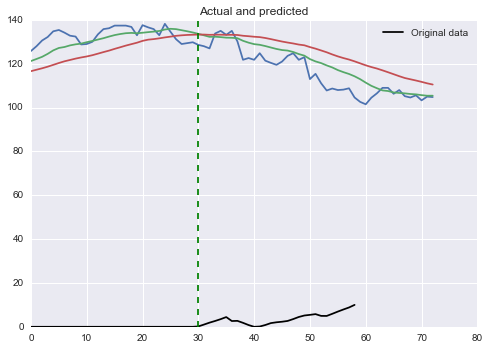

In [68]:
plt.title('Actual and predicted')
plt.legend(loc='best')
plt.plot(original, color='black', label = 'Original data')
plt.plot(original_to_show)

indicator = original

colors = ['green', 'orange', 'red']
styles = ['-', '--']
for i in intersections:
    try:
        if indicator[i] < 4:
            color = colors[0]
            style = styles[1]
        elif indicator[i] >= 4 and indicator[i] < 7:
            color = colors[1]
            style = styles[0]
        else:
            color = colors[2]
            style = styles[0]
        plt.axvline(i, color = color, linestyle = style)
    except:
        continue

plt.legend()
plt.show()   

In [69]:
print (np.mean(np.square(pred - Y_test)))
print (np.mean(np.abs(pred - Y_test)))
print (np.mean(np.abs((Y_test - pred) / Y_test)))

0.154183201967
0.303965285687
1.25863740066
